<a href="https://colab.research.google.com/github/ncsu-landscape-dynamics/LAMP_assay_automation/blob/main/PyTorchImSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install rawpy

     |████████████████████████████████| 1.7MB 8.1MB/s 


In [4]:
pip install -q git+https://github.com/tensorflow/examples.git

In [7]:
import numpy as np
import os
import sys
import PIL
import PIL.Image
import glob
import rawpy
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import imageio
import scipy
import scipy.misc
import skimage.filters
import skimage.metrics
import pandas as pd
import pathlib
import tensorflow_datasets as tfds
from keras_preprocessing import image
try:
  from scipy import linalg  # pylint: disable=unused-import
  from scipy import ndimage  # pylint: disable=unused-import
except ImportError:
  pass

In [5]:
cd 'drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection'

/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection


In [ ]:
print(tf.__version__)
os.getcwd()

2.4.1


'/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection'

In [8]:
data_path = pathlib.Path.cwd()

In [ ]:
# There is another drive as i_BMP that is called i_PNG and has PNG instead of BMP
bmp_data_path = os.path.join(pathlib.Path(), 'i_BMP')

In [9]:
data_gen_def = tf.keras.preprocessing.image.ImageDataGenerator()

list1 = tf.keras.preprocessing.image.DirectoryIterator(bmp_data_path, data_gen_def)

NameError: ignored

In [ ]:
#This is old, but will keep around: image1 = tf.io.decode_raw(glob.glob('*.dng')[0], tf.int32)

In [ ]:
os.listdir(bmp_data_path)

['bmp_zero_min', 'bmp_sixty_min']

In [10]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [11]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8JR36V/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete8JR36V/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [15]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [16]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [17]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [18]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [19]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [20]:
type(train)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [22]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [23]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Mask', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

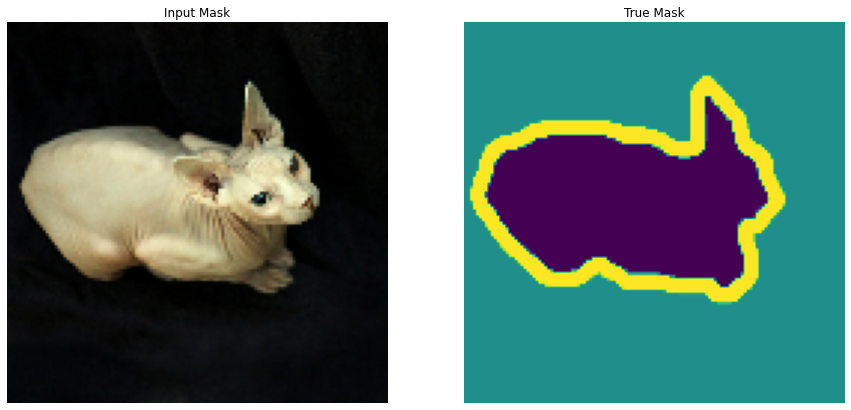

In [24]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [25]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu', 
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'
]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [26]:
up_stack = [ 
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [28]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [27]:
def unet_model(output)

SyntaxError: ignored